In [ ]:
# import emarci Libary
from emarci import tradingSimulation as ts

# import pandas
import pandas as pd
import numpy as np

In [56]:
price_data = ts.yfDownloadMaxPeriod(["GOOG", "AAPL"], "1m")
price_data

[*********************100%***********************]  2 of 2 completed


Price                  Price                    High                     Low  \
Ticker                  AAPL        GOOG        AAPL        GOOG        AAPL   
Date                                                                           
2025-02-14 18:18  244.100006  186.860001  244.119995  186.899994  244.014999   
2025-02-14 18:19  244.130005  186.725006  244.179993  186.889999  244.107193   
2025-02-14 18:20  244.109695  186.720001  244.134995  186.792099  244.050995   
2025-02-14 18:21  244.100006  186.729996  244.205002  186.820007  244.100006   
2025-02-14 18:22  244.184998  186.660004  244.199997  186.740005  244.085007   
...                      ...         ...         ...         ...         ...   
2025-02-21 18:13  247.325394  181.960098  247.419998  182.029999  247.244995   
2025-02-21 18:14  247.309998  182.154999  247.410004  182.164993  247.259995   
2025-02-21 18:15  247.279999  182.304993  247.410004  182.349899  247.229996   
2025-02-21 18:16  247.160004  182.449997  247.279999  182.479996  247.100006   
2025-02-21 18:17  247.190002  182.500000  247.190002  182.500000  247.190002   

Price                         
Ticker                  GOOG  
Date                          
2025-02-14 18:18  186.839996  
2025-02-14 18:19  186.725006  
2025-02-14 18:20  186.700104  
2025-02-14 18:21  186.720200  
2025-02-14 18:22  186.660004  
...                      ...  
2025-02-21 18:13  181.830505  
2025-02-21 18:14  182.000000  
2025-02-21 18:15  182.160004  
2025-02-21 18:16  182.300003  
2025-02-21 18:17  182.500000  

[1557 rows x 6 columns]

In [342]:
class engineSimple:
    """
    Inputs:
    "insert text here"

    Output: 
    "insert text here"
    """

    # function: __init__
    def __init__(self, price_data, commission_rate, initial_balance):
    
        # set self.X (Variables Fixed)
        self.price_data = price_data
        self.commission_rate = commission_rate

        # set self.X (variables Non-fixed)
        self.total_commission_costs = 0
        self.balance = initial_balance
        self.PnL = 0
        self.PnL_without_commisions = 0

        # Create empty pandas DataFrames
        df_trade_positions = pd.DataFrame([[None]*(len(price_data.columns.levels[1].values)*2)],
                                                   index=[0],
                                                   columns= pd.MultiIndex.from_product([["Trade Direction", "Trade Volume"], price_data.columns.levels[1].values], names=['Category', 'Ticker']))
        df_trade_history = pd.DataFrame([[None]*7],
                                                 index=[0],
                                                 columns=["Date", "Ticker", "Action", "Trade Volume", "Price", "Type", "Commission Fee"])

        # set index name of pandas DataFrames 
        df_trade_positions.index.name = "Date"
        df_trade_history.index.name = "Entry"

        # set self.X (pandas DataFrames)
        self.trade_positions = df_trade_positions.drop(0)
        self.trade_history = df_trade_history.drop(0)

    # function: executeMarketOrder
    def executeMarketOrder(self, ticker, action, trade_volume, date):

        # trade info
        current_price = self.price_data["Price", ticker].loc[date]
        commission_fee = self.commission_rate * current_price * trade_volume

        # update trade history
        self.trade_history.loc[len(self.trade_history.index)] = [date, ticker, action, trade_volume, current_price, "Market Order", commission_fee]
        
        # update balance
        if action == "BUY":
            self.balance -= current_price * trade_volume - commission_fee
        elif action == "SELL":
            self.balance += current_price * trade_volume - commission_fee

        # update total commission fee
        self.total_commission_costs  = self.trade_history["Commission Fee"].sum()

        # seperate BUY and SELL orders
        buy_orders = self.trade_history[(self.trade_history["Action"] == "BUY").values]
        sell_orders = self.trade_history[(self.trade_history["Action"] == "SELL").values]

        # Calculate Total Trade Volume (List)
        total_trade_volume = (buy_orders.groupby("Ticker")["Trade Volume"].sum()).sub(sell_orders.groupby("Ticker")["Trade Volume"].sum(), fill_value=0).add(pd.Series([0, 0], index=self.price_data.columns.levels[1].values), fill_value=0)
        
        # update Trade Positions
        long_short_netural = total_trade_volume.apply(lambda x: ["LONG", float(x)] if x > 0 else (["SHORT", float(x)] if x < 0 else ["NEUTRUAL", float(x)])).to_list()
        self.trade_positions.loc[date] = list(np.array(long_short_netural).T.reshape(1,4)[0])
        
        # price * trade volume from trade history database
        price_x_vol_history = self.trade_history.apply(lambda x: -(x["Price"] * x["Trade Volume"]) if x["Action"] == "BUY" else x["Price"] * x["Trade Volume"], axis=1).sum()
        price_x_vol_current = (self.trade_positions.iloc[-1]["Trade Volume"].astype(float) * self.price_data.loc["2025-02-14 18:23"]["Price"]).sum()

        # update PnL without commisions
        self.PnL_without_commisions = price_x_vol_history + price_x_vol_current

        # update PnL 
        self.PnL = self.PnL_without_commisions - self.total_commission_costs

        # pass
        pass    

    def liquidate_positions(self):

        pass  




In [350]:
engine = engineSimple(price_data, 0.0, 100000)

In [351]:
engine.executeMarketOrder("GOOG", "BUY", 10, "2025-02-14 18:21")
engine.executeMarketOrder("GOOG", "SELL", 20, "2025-02-14 18:21")
engine.executeMarketOrder("GOOG", "BUY", 10, "2025-02-14 18:22")
engine.executeMarketOrder("AAPL", "SELL", 10, "2025-02-14 18:23")

In [352]:
display(engine.trade_history)
display(engine.trade_positions)

,Date,Ticker,Action,Trade Volume,Price,Type,Commission Fee
Entry,,,,,,,
0,2025-02-14 18:21,GOOG,BUY,10,186.729996,Market Order,0.0
1,2025-02-14 18:21,GOOG,SELL,20,186.729996,Market Order,0.0
2,2025-02-14 18:22,GOOG,BUY,10,186.660004,Market Order,0.0
3,2025-02-14 18:23,AAPL,SELL,10,244.210007,Market Order,0.0


Category         Trade Direction           Trade Volume       
Ticker                      AAPL      GOOG         AAPL   GOOG
Date                                                          
2025-02-14 18:21        NEUTRUAL     SHORT          0.0  -10.0
2025-02-14 18:22        NEUTRUAL  NEUTRUAL          0.0    0.0
2025-02-14 18:23           SHORT  NEUTRUAL        -10.0    0.0

In [353]:
print(engine.balance)
print(engine.PnL)
print(engine.PnL_without_commisions)


102442.79998779297
0.699920654296875
0.699920654296875


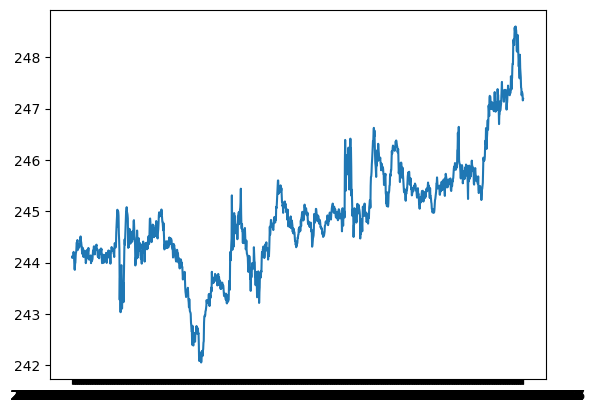

In [354]:
from matplotlib import pyplot as plt

plt.plot(price_data["Price", "AAPL"])